# Building NLP Applications with Hugging Face

About this project:
- **sentiment analysis** (i.e. categorizing text as negative or positive);
- **text embedding** (i.e. transforming a piece of text into a numerical, n-dimensional vector, representation);
- **semantic search** (i.e. matching a query with the most appropriate result based on embeddings);

The dataset comes from "Rent the Runway" [link](https://cseweb.ucsd.edu//~jmcauley/datasets.html#clothing_fit) and is comprised of user reviews on clothing items, their ratings on fit, and other metadata about the user (i.e. gender, height, size, age, reason for renting) and the item (i.e. category).


## Task 0: Setup

In [ ]:
# Import the other required packages and modules.
import pandas as pd
import numpy as np
import datetime
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import semantic_search

# From the IPython.display package, import display and Markdown
from IPython.display import display, Markdown

## Task 1: Import the Runway Data

In [ ]:
# Read the data from runway.csv
runway = pd.read_csv("runway.csv", parse_dates=['review_date'])

# Print the column info
print(runway.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1506 entries, 0 to 1505
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      1506 non-null   int64         
 1   item_id      1506 non-null   int64         
 2   rating       1506 non-null   int64         
 3   rented for   1506 non-null   object        
 4   review_text  1506 non-null   object        
 5   category     1506 non-null   object        
 6   height       1503 non-null   object        
 7   size         1506 non-null   int64         
 8   age          1500 non-null   float64       
 9   review_date  1506 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(4), object(4)
memory usage: 117.8+ KB
None


## Task 2: Preprocessing the `review_text`

In [ ]:
# Remove the forward-slash character
runway['review_text_cleaned'] = runway['review_text'].str.replace(r"\/", "")

# Remove punctuation
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.translate(string.punctuation)

# Remove digits
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.replace(r"\d+","")

# Remove running spaces
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.replace(r"\s{2,}","")

# Make the text lowercase
runway['review_text_cleaned'] = runway['review_text_cleaned'].str.lower()

## Task 3: Sentiment Analysis on `review_text_cleaned`

In [ ]:
model = "distilbert-base-uncased-finetuned-sst-2-english"

# Instantiate the new pipeline() object for sentiment analysis. Include the model defined above as the model input.
sentimentAnalysis = pipeline('sentiment-analysis', model=model)

# Run sentiment analysis on the cleaned review text.
sent_analysis_output = sentimentAnalysis(list(runway['review_text_cleaned']))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


## Task 4: Histogram of Sentiment Score

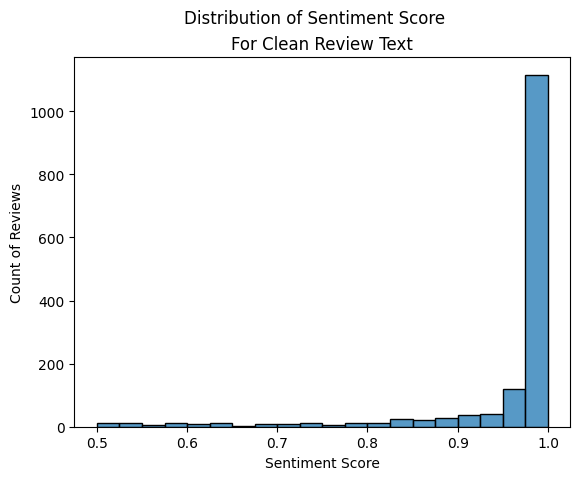

In [ ]:
# Parse out the two pieces of output from sent_analysis_output - "label" and "score".
runway['clean_sentiment_category'] = [s['label'] for s in sent_analysis_output]
runway['clean_sentiment_score'] = [s['score'] for s in sent_analysis_output]

# Create the first histogram using the built-in Pandas histogram method.
sns.histplot(data=runway, x='clean_sentiment_score', bins=20)
plt.suptitle("Distribution of Sentiment Score")
plt.xlabel("Sentiment Score")
plt.ylabel("Count of Reviews")
plt.title("For Clean Review Text")
plt.show()

## Task 5: Sentiment Over the Years

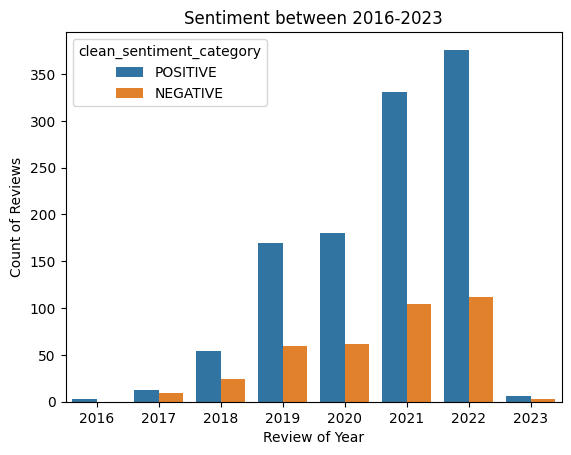

In [ ]:
# Create a new column called "year" which is the year of the "review_date".
runway['year'] = runway['review_date'].dt.year

# Create a new dataframe of review counts by "year" and "cleaned_sentiment_category".
chart_data = runway.groupby(['year','clean_sentiment_category'], as_index=False)['user_id'].count()
chart_data.columns = ['year','clean_sentiment_category','cnt']

# Create a bar plot showing the count of reviews for each sentiment category over the years.
sns.barplot(data=chart_data, x='year', y='cnt', hue='clean_sentiment_category', errorbar=None)
plt.title('Sentiment between 2016-2023')
plt.xlabel('Review of Year')
plt.ylabel('Count of Reviews')
plt.show()

## Task 6: Does Cleaning Text Matter?

In [ ]:
# Create a new sentiment analysis output for "review_text".
sent_analysis_2 = sentimentAnalysis(list(runway['review_text']))

# Parse the output into "sentiment_category" and "sentiment_score".
runway['sentiment_category'] = [s['label'] for s in sent_analysis_2]
runway['sentiment_score'] = [s['score'] for s in sent_analysis_2]

# Print the confusion matrix comparing the two sentiment category outputs.
display(pd.crosstab(runway['clean_sentiment_category'], runway['sentiment_category']))

sentiment_category,NEGATIVE,POSITIVE
clean_sentiment_category,,
NEGATIVE,373,1
POSITIVE,2,1130


##Task 7: Checking the accuracy

In [ ]:
from sklearn.metrics import accuracy_score

ground_truth_labels = runway['clean_sentiment_category'].copy()
ground_truth_labels[runway['clean_sentiment_score'] >= 0.93] = "POSITIVE"
ground_truth_labels[runway['clean_sentiment_score'] <= 0.3] = "NEGATIVE"

# Filter out reviews not labeled as "POSITIVE" or "NEGATIVE"
filtered_indices = ground_truth_labels.isin(["POSITIVE", "NEGATIVE"])
ground_truth_labels = ground_truth_labels[filtered_indices]
predicted_labels = runway['clean_sentiment_category'][filtered_indices]

# Compute accuracy
distilbert_accuracy = accuracy_score(ground_truth_labels, predicted_labels)

print(f"DistilBERT Sentiment Analysis Accuracy: {distilbert_accuracy:.2%}")

DistilBERT Sentiment Analysis Accuracy: 82.40%


## Task 8: Embeddings

In [ ]:
model_id = "sentence-transformers/all-MiniLM-L6-v2"

# Instantiate a new SentenceTransformer object.
model = SentenceTransformer(model_id)

# Generate the embeddings for the "rented for" column.
embeddings = model.encode(list(runway['rented for']))

print(embeddings.shape)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(1506, 384)


## Task 9: Semantic Search

In [ ]:
# Define query
query = "a gorgeous and flattering dress"

# Embed query
query_emb = model.encode(query, convert_to_tensor=True)

# Calculate similarity between query and item embeddings
hits = semantic_search(query_emb, embeddings, top_k=3)

# Print top similar items
for hits in hits[0]:
    idx = hits['corpus_id']
    print(
        "ITEM ID: ", runway.iloc[idx]['item_id'],
        "; RENTED FOR: ", runway.iloc[idx]['rented for'],
        "; REVIEW: ", runway.iloc[idx]['review_text']
    )

ITEM ID:  652189 ; RENTED FOR:  wedding ; REVIEW:  even though it was lined with satin this was a light beachy dress that was still formal enough for this casual beach weddingitsbackless though so you cant wear a bra and because the neck is such a scoopneck it makes the neckline a little strange if you have a chest and dont wear onei ended up getting one of those stick on bras and the dress looked much betterits much pinker than the model picture which was a pleasant surprisepretty dress comfortable just a little awkward fitting in the chest area if you have anything larger than an abuy the stick on bra
ITEM ID:  1498329 ; RENTED FOR:  wedding ; REVIEW:  the dress was gorgeous but unfortunately i was unable to wear it due to some quality issues which the renttherunway team was excellent at handlingi would recommend going upsizes from your usual dress size if you have a larger bustit also runs on the long side imand even withinch heels it dragged a little too much for my preferencethe c

## Task 10: Generate New Marketing Material

In [ ]:
# Instantiate the pipeline for generating text
generator = pipeline(model='gpt2')

# Pre-defined prompt
prompt = "New for this winter season, a lovely dress that"

# Use the prompt as input to the generator to return output.
output = generator(prompt, num_return_sequences = 1, return_full_text = False)

# Print the generated text.
print("New marketing Campaign: ", prompt, output[0]['generated_text'])

Device set to use cuda:0
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


New marketing Campaign:  New for this winter season, a lovely dress that  will keep you warm and damp. The dress also contains a lovely pink lace embellishment (no zipper required), and it is absolutely perfect for this winter. For this price, you'll surely be happy


##Task 11: Calculating precision for semantic search result

In [78]:
from sklearn.metrics import precision_score

# Define query
query = "a gorgeous and flattering dress"

# Define ground truth relevant items
ground_truth_relevant_items = {
    query: [652189, 1498329, 1879504]  # Replace with actual values
}

# Debugging: Print hits structure
print("Hits structure:", hits)

# Ensure `hits` is iterable and extract item IDs
retrieved_items = []
if isinstance(hits, dict) and 'corpus_id' in hits:
    item_id = runway.iloc[int(hits['corpus_id'])]['item_id']
    retrieved_items.append(item_id)

# Debugging: Print retrieved items
print("Retrieved Items:", retrieved_items)

# Compute precision only if retrieved items exist
if retrieved_items:
    relevant_items = ground_truth_relevant_items.get(query, [])
    true_positives = sum(1 for item in retrieved_items if item in relevant_items)
    precision = true_positives / len(retrieved_items)
    print(f"Semantic Search Precision: {precision:.2%}")
else:
    print("No retrieved items found, precision cannot be calculated.")


Hits structure: {'corpus_id': 3, 'score': 0.3215046226978302}
Retrieved Items: [1879504]
Semantic Search Precision: 100.00%
